In [17]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'icv83551/assignments/assignment1/'
FOLDERNAME = 'icv83551/assignments/assignment1/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/icv83551/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/icv83551/assignments/assignment1/icv83551/datasets
/content/drive/My Drive/icv83551/assignments/assignment1


# Softmax Classifier exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission.

In this exercise you will:
    
- Implement a fully-vectorized **loss function** for the Softmax classifier.
- Implement the fully-vectorized expression for its **analytic gradient**
- **Check your implementation** using numerical gradient
- Use a validation set to **tune the learning rate and regularization** strength
- **Optimize** the loss function with **SGD**
- **Visualize** the final learned weights


In [18]:
# Run some setup code for this notebook.
import random
import numpy as np
from icv83551.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

#%load_ext autoreload
#%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [19]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'icv83551/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Clear previously loaded data.
Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


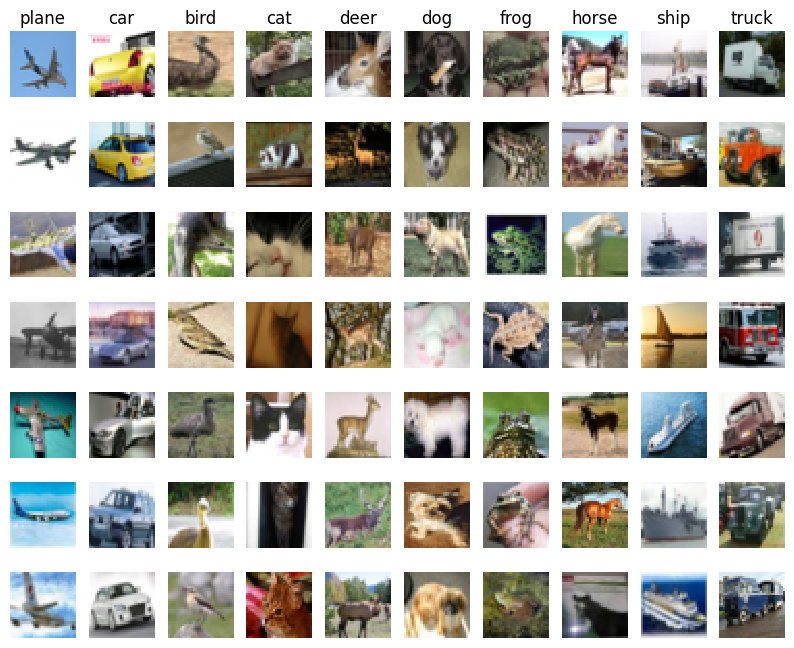

In [20]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [21]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [22]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


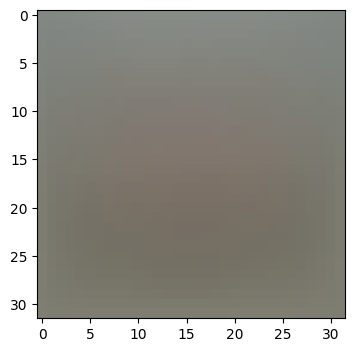

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [23]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our classifier
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## Softmax Classifier

Your code for this section will all be written inside `icv83551/classifiers/softmax.py`.

As you can see, we have prefilled the function `softmax_loss_naive` which uses for loops to evaluate the softmax loss function.

In [24]:
# Evaluate the naive implementation of the loss we provided for you:
from icv83551.classifiers.softmax import softmax_loss_naive
import time

# generate a random Softmax classifier weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001

loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.335970
loss: 2.335970
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ randn as used in the above code block will create a matrix with 10 columns which represents 10 classes. each matrix value sampled from a standard distribuation, resulting with very small class wieghts after the 0.0001 multplication. that's effectivly means all classes would have about the same probabilty of ~0.1. since softmax loss is negative log likelihood, we expact the mentioned -log(0.1).  



The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the softmax loss function and implement it inline inside the function `softmax_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [25]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from icv83551.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 0.554841 analytic: 0.554841, relative error: 2.196936e-08
numerical: -0.593090 analytic: -0.593090, relative error: 1.285923e-07
numerical: 3.637628 analytic: 3.637628, relative error: 1.923688e-08
numerical: 0.478653 analytic: 0.478653, relative error: 2.355999e-08
numerical: -2.962810 analytic: -2.962810, relative error: 1.081169e-08
numerical: -0.501273 analytic: -0.501273, relative error: 1.727178e-08
numerical: -1.801776 analytic: -1.801776, relative error: 5.340300e-09
numerical: 1.929360 analytic: 1.929360, relative error: 8.466272e-09
numerical: -0.743236 analytic: -0.743236, relative error: 1.913719e-08
numerical: 0.044686 analytic: 0.044686, relative error: 1.747602e-07
numerical: 0.995159 analytic: 0.995158, relative error: 2.477874e-09
numerical: 1.476460 analytic: 1.476460, relative error: 3.892875e-08
numerical: -1.607623 analytic: -1.607623, relative error: 8.018994e-09
numerical: -0.167584 analytic: -0.167584, relative error: 4.990785e-08
numerical: -1.012962

**Inline Question 2**

Although gradcheck is reliable softmax loss, it is possible that for SVM loss, once in a while, a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a svm loss gradient check could fail? How would change the margin affect of the frequency of this happening?

Note that SVM loss for a sample $(x_i, y_i)$ is defined as: $$L_i = \sum_{j\ne y_i}\max(0, s_j - s_{y_i} + \Delta)$$ Where $j$ iterates over all classes except the correct class $y_i$ and $s_j$ denotes the classifier score for $j^{th}$ class. $\Delta$ is a scalar margin.
*Hint: the SVM loss function is not strictly speaking differentiable.*


$\color{blue}{\textit Your Answer:}$ gradcheck compares analytic and numerical gradients, which can be computed when the loss function is smooth and differentiable everywhere. this is the case for softmax loss but not for SVM - which has a hinge (max) term - hence it can fail. additionaly, this is exactly why "it is not a reason for concern", because the non-differentiability makes occasional mismatches expected. a simple 1D example is the hinge loss we've mentioned - L(x) = max(0,x), this loss is not differentiable at x = 0 hence numerical and analytical gradients can be different. increasing the margin delta makes the hinge boundary occur more often, so gradient check failures become more frequent, while a smaller margin reduces the likelihood this will happen.



In [26]:
# Next implement the function softmax_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from icv83551.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, _ = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 2.335970e+00 computed in 0.059366s
Vectorized loss: 2.335970e+00 computed in 0.014241s
difference: 0.000000


In [27]:
# Complete the implementation of softmax_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.120578s
Vectorized loss and gradient: computed in 0.008847s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss. Your code for this part will be written inside `icv83551/classifiers/linear_classifier.py`.

In [28]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from icv83551.classifiers import Softmax
softmax = Softmax()
tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 769.677625
iteration 100 / 1500: loss 282.567896
iteration 200 / 1500: loss 104.657515
iteration 300 / 1500: loss 39.610922
iteration 400 / 1500: loss 15.890592
iteration 500 / 1500: loss 7.120845
iteration 600 / 1500: loss 3.957870
iteration 700 / 1500: loss 2.736673
iteration 800 / 1500: loss 2.345276
iteration 900 / 1500: loss 2.174065
iteration 1000 / 1500: loss 2.162222
iteration 1100 / 1500: loss 2.116136
iteration 1200 / 1500: loss 2.088411
iteration 1300 / 1500: loss 2.090866
iteration 1400 / 1500: loss 2.094898
That took 5.366292s


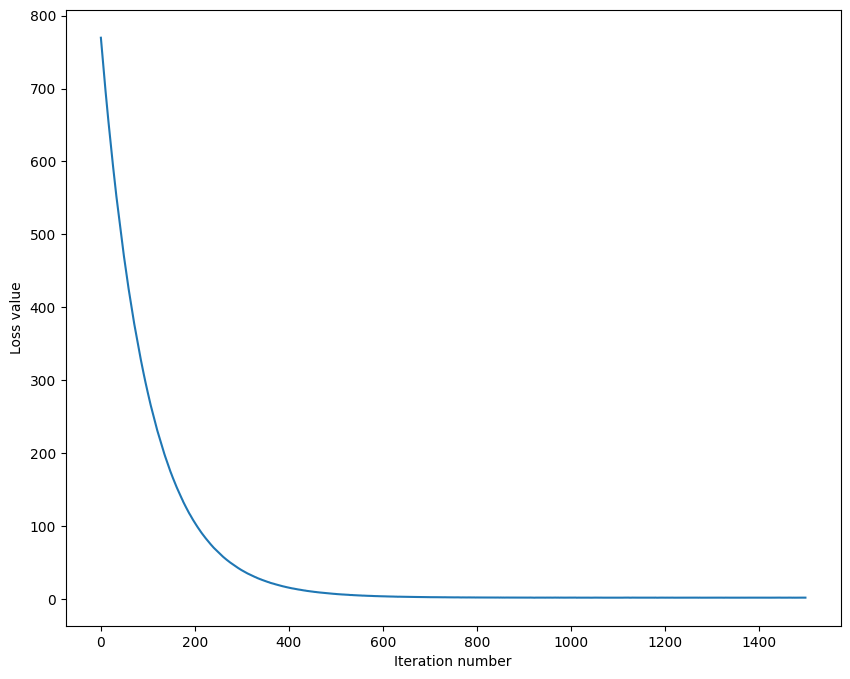

In [29]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [30]:
# Write the LinearClassifier.predict function and evaluate the performance on
# both the training and validation set
# You should get validation accuracy of about 0.34 (> 0.33).
y_train_pred = softmax.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.329102
validation accuracy: 0.346000


In [31]:
# Save the trained model for autograder.
softmax.save("softmax.npy")

softmax.npy saved.


In [36]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.365 (> 0.36) on the validation set.

# Note: you may see runtime/overflow warnings during hyper-parameter search.
# This may be caused by extreme values, and is not a bug.

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.

# grid def:
learning_rates = np.logspace(-7, -4, 7)
regularization_strengths = np.logspace(3, 5.5, 6)
batch_sizes = [50, 100, 200, 400]

results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_softmax = None # The Softmax object that achieved the highest validation rate.
max_iter = 1500
trial = 1
n_trials = len(learning_rates) * len(regularization_strengths) * len(batch_sizes)

for lr in learning_rates:
    for reg in regularization_strengths:
      for bs in batch_sizes:
          softmax = Softmax()
          print(f"starting trial {trial} / {n_trials}")
          softmax.train(
              X_train, y_train,
              learning_rate=lr,
              reg=reg,
              num_iters=max_iter,
              batch_size=bs,
              verbose=False
          )

          # Evaluate on train and val
          y_train_pred = softmax.predict(X_train)
          train_acc = np.mean(y_train_pred == y_train)

          y_val_pred = softmax.predict(X_val)
          val_acc = np.mean(y_val_pred == y_val)

          # Store results
          results[(lr, reg, bs)] = (train_acc, val_acc)

          # Track the best model
          if val_acc > best_val:
              best_val = val_acc
              best_softmax = softmax

          print("trial is done!")
          trial += 1

# Print out results.
for lr, reg, bs in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg, bs)]
    print('lr %e reg %e bs %d train accuracy: %f val accuracy: %f' % (
                lr, reg, bs, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

starting trial 1 / 168
trial is done!
starting trial 2 / 168
trial is done!
starting trial 3 / 168
trial is done!
starting trial 4 / 168
trial is done!
starting trial 5 / 168
trial is done!
starting trial 6 / 168
trial is done!
starting trial 7 / 168
trial is done!
starting trial 8 / 168
trial is done!
starting trial 9 / 168
trial is done!
starting trial 10 / 168
trial is done!
starting trial 11 / 168
trial is done!
starting trial 12 / 168
trial is done!
starting trial 13 / 168
trial is done!
starting trial 14 / 168
trial is done!
starting trial 15 / 168
trial is done!
starting trial 16 / 168
trial is done!
starting trial 17 / 168
trial is done!
starting trial 18 / 168
trial is done!
starting trial 19 / 168
trial is done!
starting trial 20 / 168
trial is done!
starting trial 21 / 168
trial is done!
starting trial 22 / 168
trial is done!
starting trial 23 / 168
trial is done!
starting trial 24 / 168
trial is done!
starting trial 25 / 168
trial is done!
starting trial 26 / 168
trial is d

/content/drive/My Drive/icv83551/assignments/assignment1/icv83551/classifiers/softmax.py:71: RuntimeWarning: overflow encountered in subtract
  scores -= np.max(scores, axis=1, keepdims=True)


trial is done!
starting trial 158 / 168
trial is done!
starting trial 159 / 168
trial is done!
starting trial 160 / 168
trial is done!
starting trial 161 / 168
trial is done!
starting trial 162 / 168
trial is done!
starting trial 163 / 168
trial is done!
starting trial 164 / 168
trial is done!
starting trial 165 / 168
trial is done!
starting trial 166 / 168
trial is done!
starting trial 167 / 168
trial is done!
starting trial 168 / 168
trial is done!
lr 1.000000e-07 reg 1.000000e+03 bs 50 train accuracy: 0.259939 val accuracy: 0.290000
lr 1.000000e-07 reg 1.000000e+03 bs 100 train accuracy: 0.263633 val accuracy: 0.262000
lr 1.000000e-07 reg 1.000000e+03 bs 200 train accuracy: 0.262143 val accuracy: 0.260000
lr 1.000000e-07 reg 1.000000e+03 bs 400 train accuracy: 0.267837 val accuracy: 0.282000
lr 1.000000e-07 reg 3.162278e+03 bs 50 train accuracy: 0.306633 val accuracy: 0.307000
lr 1.000000e-07 reg 3.162278e+03 bs 100 train accuracy: 0.306776 val accuracy: 0.317000
lr 1.000000e-07 reg

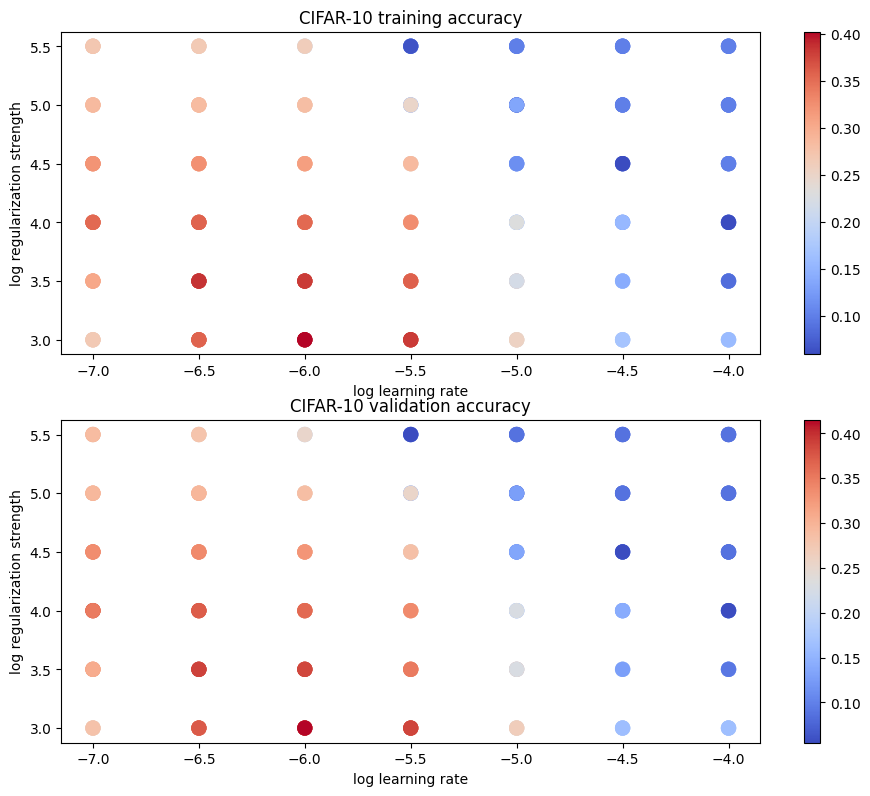

In [37]:
# Visualize the cross-validation results
import math
import pdb

# pdb.set_trace()

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [38]:
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('Softmax classifier on raw pixels final test set accuracy: %f' % test_accuracy)

Softmax classifier on raw pixels final test set accuracy: 0.391000


In [39]:
# Save best softmax model
best_softmax.save("best_softmax.npy")

best_softmax.npy saved.


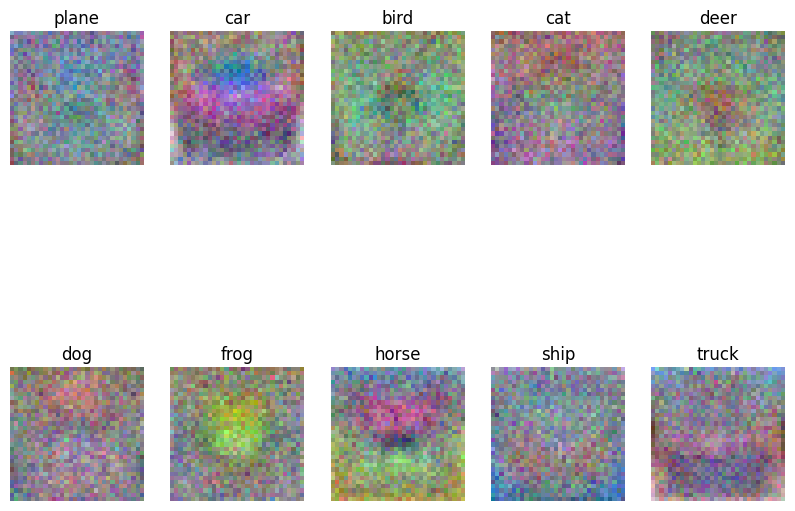

In [40]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**Inline question 3**

Describe what your visualized Softmax classifier weights look like, and offer a brief explanation for why they look the way they do.

$\color{blue}{\textit Your Answer:}$ the classifier looks like a blurry signature of the class, captures mostly coarse patterns and core characteristics. this happens due to the fact that the softmax is a linear classifier and it lacks the ability to capture more complex structures of the classes.  


**Inline Question 4** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would change the softmax loss, but leave the SVM loss unchanged.

$\color{blue}{\textit Your Answer:}$ True


$\color{blue}{\textit Your Explanation:}$ in SVM, loss term for correctly classified samples that satisfy the margin is zero, hence, if we add such examples to the training set there won't be any change in the total SVM loss (as defined - sum of samples loss). in contrast, softmax loss is defined as the negative log of the class probability (computed using an exponential over the sum of exponentials). this metric is strictly positive for any finite score, and therefore even a correctly classified sample contributes a nonzero loss, so adding it changes the overall softmax loss.